# Calculating a Typical Meteorological Year -- Methodology Walkthrough
<br>This notebook walks through the process of calculating a [Typical Meteorological Year](https://nsrdb.nrel.gov/data-sets/tmy), a specific kind of `Climate Profile` hourly dataset used for applications in energy and building systems modeling. Because this represents average rather than extreme conditions, an TMY dataset is not suited for designing systems to meet the worst-case conditions occurring at a location. 

The TMY methodology here mirrors that of the Sandia/NREL TMY3 methodology, and uses historic and projected downscaled climate data available through the Cal-Adapt: Analytics Engine catalog. As this methodology heavily weights the solar radiation input data, be aware that the final selection of "typical" months may not be typical for other variables. 

**Intended Application** As a user, I want to <span style="color:#FF0000">**generate a typical meteorological year file**</span> for a location of interest:
- Understand the methods that are involved in generating a TMY dataset
- Visualize the TMY dataset across all input variables
- Export the TMY dataset for available models for input into my workflow

**Note**: 
1. This notebook is a **full demonstration** of the Typical Meteorological Year methodology, for full transparency.
2. For practical generation of a TMY dataset, a <span style="color:#FF0000">**custom Climate Profile generation notebook**</span> is forthcoming, where a user only needs to provide the **location**, and **reference time period**. Stay tuned!

**Runtime**: With the default settings, this notebook takes approximately **40+ minutes** to run from start to finish. Modifications to selections may increase the runtime.

### Step 0: Set-up

Import the [climakitae](https://github.com/cal-adapt/climakitae) library and other dependencies.

In [1]:
from climakitae.util.utils import (
    convert_to_local_time,
    get_closest_gridcell,
)
from climakitae.core.data_export import write_tmy_file
from climakitae.core.data_interface import get_data
#from climakitaegui.explore.typical_meteorological_year import plot_one_var_cdf

import pandas as pd
import xarray as xr
import numpy as np
import pkg_resources
from tqdm.auto import tqdm  # Progress bar

import warnings
warnings.filterwarnings("ignore")

### Step 1: Grab and process all required input data

The [TMY3 method](https://www.nrel.gov/docs/fy08osti/43156.pdf) selects a "typical" month based on ten daily variables: max, min, and mean air and dew point temperatures, max and mean wind speed, global irradiance and direct irradiance.  

#### Step 1a: Select location of interest
TMYs are calculated for a specific location of interest, like a building or power plant. Here, we will use a known weather station location, via their latitude and longitude to extract the data that we need to calculate the TMY. In the example below, we will look specifically at Los Angeles International Airport, but will note in the code below how you can provide your own location coordinates too. 

In [2]:
# read in station file of CA HadISD stations
stn_file = pkg_resources.resource_filename("climakitae", "data/hadisd_stations.csv")
stn_file = pd.read_csv(stn_file, index_col=[0])
stn_file.head(5)

,state,station,city,ID,LAT_Y,LON_X,station id,elevation
0,CA,Bakersfield Meadows Field (KBFL),Bakersfield,KBFL,35.43424,-119.05524,72384023155,149.3
1,CA,Blythe Asos (KBLH),Blythe,KBLH,33.61876,-114.71451,74718823158,120.4
2,CA,Burbank-Glendale-Pasadena Airport (KBUR),Burbank,KBUR,34.19966,-118.36543,72288023152,222.7
3,CA,Needles Airport (KEED),Needles,KEED,34.76783,-114.61842,72380523179,270.6
4,CA,Fresno Yosemite International Airport (KFAT),Fresno,KFAT,36.77999,-119.72016,72389093193,101.9


In [3]:
# grab airport
stn_name = "Bakersfield Meadows Field (KBFL)"
stn_code = stn_file.loc[stn_file["station"] == stn_name]["station id"].item()
one_station = stn_file.loc[stn_file["station"] == stn_name]
stn_lat = one_station.LAT_Y.item()
stn_lon = one_station.LON_X.item()
stn_state = one_station.state.item()
stn_lat, stn_lon

(35.43424, -119.05524)

In [4]:
print(stn_code)

72384023155


Alternatively, you may want to provide your own location instead of one of the HadISD stations above. If so, uncomment the cell below by removing the `#` symbol and modifying the lines of code. Note, with custom locations, if an elevation is not provided, a default value of 0.0 m will be used. 

In [5]:
## provide your own location, via latitude and longitude coordinates
# stn_lat = YOUR_LAT_HERE
# stn_lon = YOUR_LON_HERE
# stn_state = 'YOUR_STATE_HERE'
# stn_name = 'YOUR_STATION_NAME_HERE'
# stn_code = 'custom'
# stn_elev = YOUR_ELEV_HERE # meters

#### Step 1b: Select time frame of interest
The second required input for generating a TMY dataset is the **time frame of interest**. The recommended minimum number of input years for a TMY dataset is 15-20 years worth of daily data; we will use 30 years to represent a standard climatological period. For data post-2014, we will utilize SSP 3-7.0, although scenario selection in the near-future is relatively independent. If calculating a TMY for the far-future, **carefully consider which scenario SSP to include**, as there will be **significant** differences present. 

We will also process the data for our designated station location (latitude, and longitude) at 3 km over the <span style="color:#FF0000">1990-2020 period</span> as an example. **Note**: An additional year (2021) is also loaded to pad the end of the dataset after converting to local time in the next few steps -- this is done for you when subsetting for the data. 

In [6]:
# selected reference period
start_year = 1990
end_year = 2020

#### Step 1c: Retrieve variables in catalog
It is important to note that not all models in the Cal-Adapt: Analytics Engine have the solar variables critical for TMY file generation - in fact, only 4 do! We will carefully subset our variables to ensure that the same 4 models are selected for consistency. 

Lastly, because the dynamically downscaled WRF data in the Cal-Adapt: Analytics Engine is in UTC time, we'll convert to the timezone of the station we've selected. This is particularly important for the timing of solar radiation max and min, which is a critical piece of a TMY. The handy `convert_to_local_time` function corrects for this, and ensures that all data are within the same daily timestamp.

In [7]:
# selected models
data_models = [
    "WRF_EC-Earth3_r1i1p1f1",
    "WRF_MPI-ESM1-2-HR_r3i1p1f1",
    # "WRF_TaiESM1_r1i1p1f1",
    # "WRF_MIROC6_r1i1p1f1",
]

Now that we have set up the model list, let's start retrieving data! We will need to calculate summary statistics and reduce to daily timescales for the following variables:

In [8]:
# air temperature
temp_data = get_data(
    variable="Air Temperature at 2m",
    resolution="3 km",
    timescale="hourly",
    data_type="Gridded",
    units="degC",
    latitude=(stn_lat - 0.05, stn_lat + 0.05),
    longitude=(stn_lon - 0.06, stn_lon + 0.06),
    area_average="Yes",
    scenario=["Historical Climate", "SSP 3-7.0"],
    time_slice=(start_year, end_year + 1),
)

temp_data = convert_to_local_time(
    temp_data, stn_lon, stn_lat
)  # convert to local timezone, provide lon/lat because area average data lacks coordinates
temp_data = temp_data.sel({"time": slice(f"{start_year}-01-01", f"{end_year}-12-31")})
temp_data = temp_data.sel(simulation=data_models)

# max air temp
max_airtemp_data = temp_data.resample(time="1D").max()  # daily max air temp
max_airtemp_data.name = "Daily max air temperature"  # rename for clarity

# min air temp
min_airtemp_data = temp_data.resample(time="1D").min()  # daily min air temp
min_airtemp_data.name = "Daily min air temperature"  # rename for clarity

# mean air temp
mean_airtemp_data = temp_data.resample(time="1D").mean()  # daily mean air temp
mean_airtemp_data.name = "Daily mean air temperature"  # rename for clarity
mean_airtemp_data = mean_airtemp_data.compute()

Data converted to America/Los_Angeles timezone.


Retrieve and calculate max and mean wind speed:

In [9]:
# wind speed
ws_data = get_data(
    variable="Wind speed at 10m",
    resolution="3 km",
    timescale="hourly",
    data_type="Gridded",
    units="m s-1",
    latitude=(stn_lat - 0.05, stn_lat + 0.05),
    longitude=(stn_lon - 0.06, stn_lon + 0.06),
    area_average="Yes",
    scenario=["Historical Climate", "SSP 3-7.0"],
    time_slice=(start_year, end_year + 1),
)

ws_data = convert_to_local_time(
    ws_data, stn_lon, stn_lat
)  # convert to local timezone, provide lon/lat because area average data lacks coordinates
ws_data = ws_data.sel(
    {"time": slice(f"{start_year}-01-01", f"{end_year}-12-31")}
)  # your desired time slice in local time
ws_data = ws_data.sel(simulation=data_models)

# max wind speed
max_windspd_data = ws_data.resample(time="1D").max()  # daily max wind speed
max_windspd_data.name = "Daily max wind speed"  # rename for clarity

# mean wind speed
mean_windspd_data = ws_data.resample(time="1D").mean()  # daily mean wind speed
mean_windspd_data.name = "Daily mean wind speed"  # rename for clarity

Data converted to America/Los_Angeles timezone.


In [10]:
mean_windspd_data

<xarray.DataArray 'Daily mean wind speed' (scenario: 1, simulation: 2,
                                           time: 11323, y: 4, x: 5)> Size: 2MB
dask.array<transpose, shape=(1, 2, 11323, 4, 5), dtype=float32, chunksize=(1, 1, 1, 4, 5), chunktype=numpy.ndarray>
Coordinates:
  * simulation         (simulation) <U26 208B 'WRF_EC-Earth3_r1i1p1f1' 'WRF_M...
  * scenario           (scenario) <U22 88B 'Historical + SSP 3-7.0'
  * x                  (x) float64 40B -4.095e+06 -4.092e+06 ... -4.083e+06
  * y                  (y) float64 32B 1.01e+06 1.013e+06 1.016e+06 1.019e+06
    Lambert_Conformal  int64 8B 0
    lat                (y, x) float32 80B dask.array<chunksize=(4, 5), meta=np.ndarray>
    lon                (y, x) float32 80B dask.array<chunksize=(4, 5), meta=np.ndarray>
  * time               (time) datetime64[ns] 91kB 1990-01-01 ... 2020-12-31
Attributes:
    variable_id:           wind_speed_derived
    extended_description:  Wind speed at 10 meters above the Earth's surface....
    units:                 m s-1
    data_type:             Gridded
    resolution:            3 km
    frequency:             hourly
    location_subset:       ['coordinate selection']
    approach:              Time
    downscaling_method:    Dynamical
    institution:           Multiple
    grid_mapping:          Lambert_Conformal
    timezone:              America/Los_Angeles

Retrieve and calculate max, min, and mean dew point temperature:

In [11]:
# dew point temperature
dewpt_data = get_data(
    variable="Dew point temperature",
    resolution="3 km",
    timescale="hourly",
    data_type="Gridded",
    units="degC",
    latitude=(stn_lat - 0.05, stn_lat + 0.05),
    longitude=(stn_lon - 0.06, stn_lon + 0.06),
    area_average="Yes",
    scenario=["Historical Climate", "SSP 3-7.0"],
    time_slice=(start_year, end_year + 1),
)

dewpt_data = convert_to_local_time(
    dewpt_data, stn_lon, stn_lat
)  # convert to local timezone, provide lon/lat because area average data lacks coordinates
dewpt_data = dewpt_data.sel({"time": slice(f"{start_year}-01-01", f"{end_year}-12-31")})
dewpt_data = dewpt_data.sel(simulation=data_models)

# max dew point
max_dewpt_data = dewpt_data.resample(time="1D").max()  # daily max dewpoint temp
max_dewpt_data.name = "Daily max dewpoint temperature"  # rename for clarity

# min dew point
min_dewpt_data = dewpt_data.resample(time="1D").min()  # daily min dewpoint temp
min_dewpt_data.name = "Daily min dewpoint temperature"  # rename for clarity

# mean dew point
mean_dewpt_data = dewpt_data.resample(time="1D").mean()  # daily mean dewpoint temp
mean_dewpt_data.name = "Daily mean dewpoint temperature"  # rename for clarity

Data converted to America/Los_Angeles timezone.


Next, retrieve global horizontal irradiance. GHI is within the Analytics Engine catalog at daily resolutions, but for the TMY methodology, we need to calculate the total accumulated GHI received over the course of the day, so we will retrieve hourly data instead and calculate the necessary information below. The same process is repeated for the direct normal irradiance. 

In [12]:
# global irradiance
global_irradiance_data = get_data(
    variable="Instantaneous downwelling shortwave flux at bottom",
    resolution="3 km",
    timescale="hourly",
    data_type="Gridded",
    latitude=(stn_lat - 0.05, stn_lat + 0.05),
    longitude=(stn_lon - 0.06, stn_lon + 0.06),
    area_average="Yes",
    scenario=["Historical Climate", "SSP 3-7.0"],
    time_slice=(start_year, end_year + 1),
)

global_irradiance_data = convert_to_local_time(
    global_irradiance_data, stn_lon, stn_lat
)  # convert to local timezone, provide lon/lat because area average data lacks coordinates
global_irradiance_data = global_irradiance_data.sel(
    {"time": slice(f"{start_year}-01-01", f"{end_year}-12-31")}
)
global_irradiance_data = global_irradiance_data.sel(simulation=data_models)

global_irradiance_data.name = "Global horizontal irradiance"  # rename for clarity
# total global horizontal irradiance (accumulation of hourly data over a 24-hour period)
total_ghi_data = global_irradiance_data.resample(time="1D").sum()

Data converted to America/Los_Angeles timezone.


In [13]:
# direct normal irradiance
direct_irradiance_data = get_data(
    variable="Shortwave surface downward direct normal irradiance",
    resolution="3 km",
    timescale="hourly",
    data_type="Gridded",
    latitude=(stn_lat - 0.05, stn_lat + 0.05),
    longitude=(stn_lon - 0.06, stn_lon + 0.06),
    area_average="Yes",
    scenario=["Historical Climate", "SSP 3-7.0"],
    time_slice=(start_year, end_year + 1),
)

direct_irradiance_data = convert_to_local_time(
    direct_irradiance_data, stn_lon, stn_lat
)  # convert to local timezone, provide lon/lat because area average data lacks coordinates
direct_irradiance_data = direct_irradiance_data.sel(
    {"time": slice(f"{start_year}-01-01", f"{end_year}-12-31")}
)
direct_irradiance_data = direct_irradiance_data.sel(simulation=data_models)

direct_irradiance_data.name = "Direct normal irradiance"  # rename for clarity
# total direct normal irradiance (accumulation of hourly data over a 24-hour period)
total_dni_data = direct_irradiance_data.resample(time="1D").sum()

Data converted to America/Los_Angeles timezone.


#### Step 1d: Load all variables
Now that we have all of our data retrieved and calculated, it is time to actually load the data into memory. Previously, xarray has lazily loaded the data, but we will actually grab it now. This will take approximately **7 minutes**. 

In [14]:
all_vars = xr.merge(
    [
        max_airtemp_data.squeeze(),
        min_airtemp_data.squeeze(),
        mean_airtemp_data.squeeze(),
        max_dewpt_data.squeeze(),
        min_dewpt_data.squeeze(),
        mean_dewpt_data.squeeze(),
        max_windspd_data.squeeze(),
        mean_windspd_data.squeeze(),
        total_ghi_data.squeeze(),
        total_dni_data.squeeze(),
    ]
)

In [15]:
# load all indices in
all_vars = all_vars.compute()

In [16]:
all_vars

<xarray.Dataset> Size: 4MB
Dimensions:                          (simulation: 2, time: 11323, x: 5, y: 4)
Coordinates:
  * simulation                       (simulation) <U26 208B 'WRF_EC-Earth3_r1...
    Lambert_Conformal                int64 8B 0
    scenario                         <U22 88B 'Historical + SSP 3-7.0'
  * time                             (time) datetime64[ns] 91kB 1990-01-01 .....
  * x                                (x) float64 40B -4.095e+06 ... -4.083e+06
  * y                                (y) float64 32B 1.01e+06 ... 1.019e+06
    lat                              (y, x) float32 80B 35.37 35.38 ... 35.5
    lon                              (y, x) float32 80B -119.1 -119.0 ... -119.0
Data variables:
    Daily max air temperature        (simulation, time) float32 91kB 19.55 .....
    Daily min air temperature        (simulation, time) float32 91kB 7.713 .....
    Daily mean air temperature       (simulation, time) float32 91kB 12.91 .....
    Daily max dewpoint temperature   (simulation, time) float32 91kB -0.2299 ...
    Daily min dewpoint temperature   (simulation, time) float32 91kB -7.059 ....
    Daily mean dewpoint temperature  (simulation, time) float32 91kB -3.75 .....
    Daily max wind speed             (simulation, time, y, x) float32 2MB nan...
    Daily mean wind speed            (simulation, time, y, x) float32 2MB nan...
    Global horizontal irradiance     (simulation, time) float32 91kB 3.455e+0...
    Direct normal irradiance         (simulation, time) float32 91kB 8.021e+0...
Attributes:
    variable_id:           t2
    extended_description:  Temperature of the air 2m above Earth's surface. T...
    units:                 degC
    data_type:             Gridded
    resolution:            3 km
    frequency:             hourly
    location_subset:       ['coordinate selection']
    approach:              Time
    downscaling_method:    Dynamical
    institution:           UCLA
    grid_mapping:          Lambert_Conformal
    timezone:              America/Los_Angeles

### Step 2: Calculate cumulative distribution functions

For the TMY, the cumulative distribution function gives the proportion of values that are less than or equal to a specified value of the index. In this case, we want to identify months that are as close to the long-term climatology for each variable as possible, indicating months that are "typical".  

#### Step 2a: Calculate long-term climatology CDFs for each index
First, we need to calculate the long-term climatology for each index for each month so we can establish the baseline pattern. 

In [17]:
def compute_cdf(da):
    """Compute the cumulative density function for an input DataArray"""
    da_np = da.values  # Get numpy array of values
    num_samples = 1024  # Number of samples to generate
    count, bins_count = np.histogram(  # Create a numpy histogram of the values
        da_np,
        bins=np.linspace(
            da_np.min(),  # Start at the minimum value of the array
            da_np.max(),  # End at the maximum value of the array
            num_samples,
        ),
    )
    cdf_np = np.cumsum(count / sum(count))  # Compute the CDF

    # Turn the CDF array into xarray DataArray
    # New dimension is the bin values
    cdf_da = xr.DataArray(
        [bins_count[1:], cdf_np],
        dims=["data", "bin_number"],
        coords={
            "data": ["bins", "probability"],
        },
    )
    cdf_da.name = da.name
    return cdf_da


def get_cdf_by_sim(da):
    # Group the DataArray by simulation
    return da.groupby("simulation").apply(compute_cdf)


def get_cdf_by_mon_and_sim(da):
    # Group the DataArray by month in the year
    return da.groupby("time.month").apply(get_cdf_by_sim)


def get_cdf(ds):
    """Get the cumulative density function.

    Parameters
    -----------
    ds: xr.Dataset
        Input data to compute CDF for
    Returns
    -------
    xr.Dataset
    """
    return ds.apply(get_cdf_by_mon_and_sim)

In [18]:
cdf_climatology = get_cdf(all_vars)

In the plot below, we'll display maximum air temperature to assess the climatological CDF pattern, but you can modify the variable here to one of your choosing to see the pattern too! Also select a different month by moving the slider bar to see the pattern throughout the year. 

In [ ]:
# # Choose your desired variable
# var = "Daily max air temperature"

# # Make the plot
# cdf_plot = plot_one_var_cdf(cdf_climatology, var)
# display(cdf_plot)

#### Step 2b: Calculate CDFs for each index for all months

Next, we will calculate CDF for each month and each variable, for which we ultimately will compare against climatology. For the individual months, we must also exclude the period of time during a major volcanic eruption (Pinatubo: June 1991 to December 1994) as the aerosols have an impact on solar variables. The cells below functions exclude this data from our data next. 

In [19]:
def get_cdf_monthly(ds):
    """Get the cumulative density function by unique mon-yr combos

    Parameters
    -----------
    ds: xr.Dataset
        Input data to compute CDF for
    Returns
    -------
    xr.Dataset
    """

    def get_cdf_mon_yr(da):
        return da.groupby("time.year").apply(get_cdf_by_mon_and_sim)

    return ds.apply(get_cdf_mon_yr)

In [20]:
cdf_monthly = get_cdf_monthly(all_vars)

Now we'll remove the volcanic years: 

In [21]:
# Remove the years for the Pinatubo eruption
cdf_monthly = cdf_monthly.where(
    (~cdf_monthly.year.isin([1991, 1992, 1993, 1994])), np.nan, drop=True
)

Like the climatology CDF figure above, let's check out the individual months next. You can modify the variable, and month-year to display too. 

In [ ]:
# # Choose your desired variable
# var = "Daily max air temperature"

# # Make the plot
# cdf_plot_mon_yr = plot_one_var_cdf(cdf_monthly, var)
# display(cdf_plot_mon_yr)

### Step 3: Compare climatology CDF to monthly CDF for each variable

Now that we have the distributions for the long-term climatology of our 30-year period, and the corresponding distribution for each month in that 30-year period, we need to assess how each individual month compares to the long-term climatology. In essence, we are looking for the individual months that best capture the climatology distribution. 

#### Step 3a: Calculate the Finkelstein-Schafer statistic 
The [Finkelstein-Schafer statistic](https://academic.oup.com/biomet/article-abstract/58/3/641/233677) determines the absolute difference between the long-term climatology and candidate CDF profiles, and considers the number of days within each month. We will use a handy function `fs_statistic` to calculate this below. 

In [22]:
def fs_statistic(cdf_climatology, cdf_month):
    """
    Calculates the Finkelstein-Schafer statistic:
    Absolute difference between long-term climatology and candidate CDF, divided by number of days in month
    """
    days_per_mon = xr.DataArray(
        data=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
        coords={"month": np.arange(1, 13)},
    )
    fs_stat = abs(cdf_monthly - cdf_climatology).sel(data="probability") / days_per_mon
    return fs_stat

In [23]:
all_vars_fs = fs_statistic(cdf_climatology, cdf_monthly)

#### Step 3b: Weight the F-S statistic

Next, we weight the F-S statistic results based on the input variables. The [TMY3](https://www.nrel.gov/docs/fy08osti/43156.pdf) method places a higher weight on the solar variables (global irradiance and direct irradiance), which we follow here. 

In [24]:
def compute_weighted_fs(da_fs):
    """Weights the F-S statistics based on TMY3 methodology"""
    weights_per_var = {
        "Daily max air temperature": 1 / 20,
        "Daily min air temperature": 1 / 20,
        "Daily mean air temperature": 2 / 20,
        "Daily max dewpoint temperature": 1 / 20,
        "Daily min dewpoint temperature": 1 / 20,
        "Daily mean dewpoint temperature": 2 / 20,
        "Daily max wind speed": 1 / 20,
        "Daily mean wind speed": 1 / 20,
        "Global horizontal irradiance": 5 / 20,
        "Direct normal irradiance": 5 / 20,
    }

    for var, weight in weights_per_var.items():
        # Multiply each variable by it's appropriate weight
        da_fs[var] = da_fs[var] * weight
    return da_fs

In [25]:
weighted_fs = compute_weighted_fs(all_vars_fs)

#### Step 3c: Select candidate months for consideration
Once weighted, we select the top candidate months for each month that have lowest weighted sums, meaning that these candidate months are the closest to the long-term climatology for that month. 

In [26]:
# Sum
weighted_fs_sum = (
    weighted_fs.to_array().sum(dim=["variable", "bin_number"]).drop(["data"])
)

# Pass the weighted F-S sum data for simplicity
ds = weighted_fs_sum

df_list = []
num_values = (
    1  # Selecting the top value for now, persistence statistics calls for top 5
)
for sim in ds.simulation.values:
    for mon in ds.month.values:
        da_i = ds.sel(month=mon, simulation=sim)
        top_xr = da_i.sortby(da_i, ascending=True)[:num_values].expand_dims(
            ["month", "simulation"]
        )
        top_df_i = top_xr.to_dataframe(name="top_values")
        df_list.append(top_df_i)

# Concatenate list together for all months and simulations
top_df = pd.concat(df_list).drop(columns=["top_values"]).reset_index()
top_df

,month,simulation,year
0,1,WRF_EC-Earth3_r1i1p1f1,2007
1,2,WRF_EC-Earth3_r1i1p1f1,2014
2,3,WRF_EC-Earth3_r1i1p1f1,1997
3,4,WRF_EC-Earth3_r1i1p1f1,1995
4,5,WRF_EC-Earth3_r1i1p1f1,2004
5,6,WRF_EC-Earth3_r1i1p1f1,1995
6,7,WRF_EC-Earth3_r1i1p1f1,2000
7,8,WRF_EC-Earth3_r1i1p1f1,1997
8,9,WRF_EC-Earth3_r1i1p1f1,1990
9,10,WRF_EC-Earth3_r1i1p1f1,1997


The data table above represents the ideal months that represent the long term climatology based on the 10 indices for the 4 simulations in the Analytics Engine catalog. Meaning, for a "typical" meteorological year, WRF_EC-Earth3 data for Jan will come from Jan 2017, data for Feb will come from 2018, and so on. In the next step, we will generate the resulting "TMY" file that is commonly used in such applications. 

### Step 4: Generate the TMY data outputs

Generally, the following data is outputted using the TMY months:
- Date & time (UTC)
- Air temperature at 2m [°C]
- Dew point temperature [°C]
- Relative humidity [%]
- Global horizontal irradiance [W/m2]
- Direct normal irradiance [W/m2]
- Diffuse horizontal irradiance [W/m2]
- Downwelling infrared radiation [W/m2]
- Wind speed at 10m [m/s]
- Wind direction at 10m [°]
- Surface air pressure [Pa]

The following function will retrieve all of this data for the designated TMY month and concatenate it together into a pandas dataframe so that we can export it as a csv file. We'll do this next. 

In [27]:
def generate_tmy_data(top_df):
    """Generate typical meteorological year data
    Output will be a list of dataframes per simulation.
    Print statements throughout the function indicate to the user the progress of the computatioconvert_to_local_time   Parameters
    -----------
    top_df: pd.DataFrame
        Table with column values month, simulation, and year
        Each month-sim-yr combo represents the top candidate that has the lowest weighted sum from the FS statistic

    Returns
    --------
    dict of str:pd.DataFrame
        Dictionary in the format of {simulation:TMY corresponding to that simulation}

    """
    ## ================== GET DATA FROM CATALOG ==================
    vars_and_units = {
        "Air Temperature at 2m": "degC",
        "Dew point temperature": "degC",
        "Relative humidity": "[0 to 100]",
        "Instantaneous downwelling shortwave flux at bottom": "W/m2",
        "Shortwave surface downward direct normal irradiance": "W/m2",
        "Shortwave surface downward diffuse irradiance": "W/m2",
        "Instantaneous downwelling longwave flux at bottom": "W/m2",
        "Wind speed at 10m": "m s-1",
        "Wind direction at 10m": "degrees",
        "Surface Pressure": "Pa",
    }

    # Loop through each variable and grab data from catalog
    all_vars_list = []
    print("STEP 1: RETRIEVING HOURLY DATA FROM CATALOG\n")
    for var, units in vars_and_units.items():
        print(f"Retrieving data for {var}", end="... ")
        data_by_var = get_data(
            variable=var,
            resolution="3 km",
            timescale="hourly",
            data_type="Gridded",
            units=units,
            latitude=(stn_lat - 0.05, stn_lat + 0.05),
            longitude=(stn_lon - 0.06, stn_lon + 0.06),
            area_average="No",
            scenario=["Historical Climate", "SSP 3-7.0"],
            time_slice=(start_year, end_year + 1),
        )
        data_by_var = convert_to_local_time(data_by_var)  # convert to local timezone.
        data_by_var = data_by_var.sel(
            {"time": slice(f"{start_year}-01-01", f"{end_year}-12-31")}
        )  # get desired time slice in local time
        data_by_var = get_closest_gridcell(
            data_by_var, stn_lat, stn_lon, print_coords=False
        )  # retrieve only closest gridcell
        data_by_var = data_by_var.sel(
            simulation=data_models
        )  # Subset for only the models that have solar variables

        # Drop unwanted coords
        data_by_var = data_by_var.squeeze().drop(
            ["lakemask", "landmask", "x", "y", "Lambert_Conformal"]
        )

        all_vars_list.append(data_by_var)  # Append to list
        print("complete!")

    # Merge data from all variables into a single xr.Dataset object
    all_vars_ds = xr.merge(all_vars_list)

    ## ================== CONSTRUCT TMY ==================
    print(
        "\nSTEP 2: CALCULATING TYPICAL METEOROLOGICAL YEAR PER MODEL SIMULATION\nProgress bar shows code looping through each month in the year.\n"
    )
    tmy_df_all = {}
    for sim in all_vars_ds.simulation.values:
        df_list = []
        print(f"Calculating TMY for simulation: {sim}")
        for mon in tqdm(np.arange(1, 13, 1)):
            # Get year corresponding to month and simulation combo
            year = top_df.loc[
                (top_df["month"] == mon) & (top_df["simulation"] == sim)
            ].year.item()

            # Select data for unique month, year, and simulation
            data_at_stn_mon_sim_yr = all_vars_ds.sel(
                simulation=sim, time=f"{mon}-{year}"
            ).expand_dims("simulation")

            # Reformat as dataframe
            df_by_mon_sim_yr = data_at_stn_mon_sim_yr.to_dataframe()
            df_by_mon_sim_yr = df_by_mon_sim_yr.reset_index()

            # Reformat time index to remove seconds
            df_by_mon_sim_yr["time"] = pd.to_datetime(
                df_by_mon_sim_yr["time"].values
            ).strftime("%Y-%m-%d %H:%M")
            df_list.append(df_by_mon_sim_yr)

        # Concatenate all DataFrames together
        tmy_df_by_sim = pd.concat(df_list)
        tmy_df_all[sim] = tmy_df_by_sim

    return tmy_df_all  # Return dict of TMY by simulation

In the next cell, we will run the `generate_tmy_data` function which will retrieve, subset, and format the data for each month according to the TMY months for all requested variables. We have included print statements so you can watch the progress for each variable in each month as it builds. 

<span style="color:#FF0000">**Note**: <span style="color:#000000"> This will take time! On the Analytics Engine JupyterHub, this takes approximately 22 minutes. Progress bars will indicate the status of generating the TMY data for each simulation. 

In [28]:
tmy_data_to_export = generate_tmy_data(top_df)

STEP 1: RETRIEVING HOURLY DATA FROM CATALOG

Retrieving data for Air Temperature at 2m... Data converted to America/Los_Angeles timezone.
complete!
Retrieving data for Dew point temperature... Data converted to America/Los_Angeles timezone.
complete!
Retrieving data for Relative humidity... Data converted to America/Los_Angeles timezone.
complete!
Retrieving data for Instantaneous downwelling shortwave flux at bottom... Data converted to America/Los_Angeles timezone.
complete!
Retrieving data for Shortwave surface downward direct normal irradiance... Data converted to America/Los_Angeles timezone.
complete!
Retrieving data for Shortwave surface downward diffuse irradiance... Data converted to America/Los_Angeles timezone.
complete!
Retrieving data for Instantaneous downwelling longwave flux at bottom... Data converted to America/Los_Angeles timezone.
complete!
Retrieving data for Wind speed at 10m... Data converted to America/Los_Angeles timezone.
complete!
Retrieving data for Wind dir

  0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

Let's observe what the TMY data looks like for one of the simulations:

In [ ]:
simulation = "WRF_EC-Earth3_r1i1p1f1"
tmy_data_to_export[simulation].head(5)

,simulation,time,lat,lon,scenario,Air Temperature at 2m,Dew point temperature,Relative humidity,Instantaneous downwelling shortwave flux at bottom,Shortwave surface downward direct normal irradiance,Shortwave surface downward diffuse irradiance,Instantaneous downwelling longwave flux at bottom,Wind speed at 10m,Wind direction at 10m,Surface Pressure
0,WRF_EC-Earth3_r1i1p1f1,2007-01-01 00:00,35.445045,-119.060608,Historical + SSP 3-7.0,12.090851,4.243805,58.401974,0.0,0.0,0.0,296.056549,2.158408,75.386612,100118.789062
1,WRF_EC-Earth3_r1i1p1f1,2007-01-01 01:00,35.445045,-119.060608,Historical + SSP 3-7.0,12.298676,3.440125,54.418396,0.0,0.0,0.0,295.938080,2.000776,66.366058,100125.429688
2,WRF_EC-Earth3_r1i1p1f1,2007-01-01 02:00,35.445045,-119.060608,Historical + SSP 3-7.0,12.297821,2.820068,52.076118,0.0,0.0,0.0,294.639709,1.400779,48.830303,100132.648438
3,WRF_EC-Earth3_r1i1p1f1,2007-01-01 03:00,35.445045,-119.060608,Historical + SSP 3-7.0,11.743561,2.234039,51.823807,0.0,0.0,0.0,292.951294,1.531756,53.522655,100134.171875
4,WRF_EC-Earth3_r1i1p1f1,2007-01-01 04:00,35.445045,-119.060608,Historical + SSP 3-7.0,10.297516,2.115509,56.626747,0.0,0.0,0.0,292.413391,2.812064,34.556133,100133.101562


Next, we visualize the TMY data itself.

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

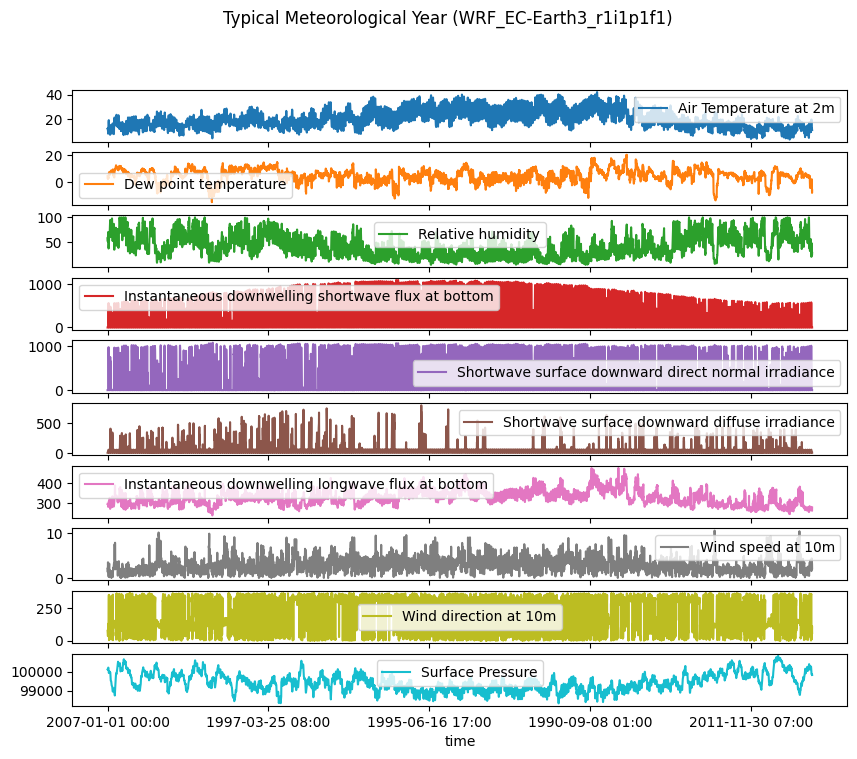

In [ ]:
tmy_data_to_export[simulation].plot(
    x="time",
    y=[
        "Air Temperature at 2m",
        "Dew point temperature",
        "Relative humidity",
        "Instantaneous downwelling shortwave flux at bottom",
        "Shortwave surface downward direct normal irradiance",
        "Shortwave surface downward diffuse irradiance",
        "Instantaneous downwelling longwave flux at bottom",
        "Wind speed at 10m",
        "Wind direction at 10m",
        "Surface Pressure",
    ],
    title=f"Typical Meteorological Year ({simulation})",
    subplots=True,
    figsize=(10, 8),
    legend=True,
)

Lastly, let's export the TMY data below as csv files. There will be a file per simulation downloaded. When utilizing TMY data in your own workflows, we recommend that **all simulations are considered** in your analyses, especially for future scenarios. Note, if you are working with a custom location, please also provide the optional `stn_elev` argument to `write_tmy_file`; if no elevation value is provided, an elevation value of 0.0 is set as the default. 

In [ ]:
for sim, tmy in tmy_data_to_export.items():
    filename = "TMY_{0}_{1}".format(
        stn_name.replace(" ", "_").replace("(", "").replace(")", ""), sim
    ).lower()
    write_tmy_file(
        filename,
        tmy_data_to_export[sim],
        (start_year, end_year),
        stn_name,
        stn_code,
        stn_lat,
        stn_lon,
        stn_state,
        file_ext="epw",
    )

TMY data exported to .epw format with filename tmy_bakersfield_meadows_field_kbfl_wrf_ec-earth3_r1i1p1f1, with size 8760
TMY data exported to .epw format with filename tmy_bakersfield_meadows_field_kbfl_wrf_mpi-esm1-2-hr_r3i1p1f1, with size 8760


### Troubleshooting

In [33]:
top_df

,month,simulation,year
0,1,WRF_EC-Earth3_r1i1p1f1,2007
1,2,WRF_EC-Earth3_r1i1p1f1,2014
2,3,WRF_EC-Earth3_r1i1p1f1,1997
3,4,WRF_EC-Earth3_r1i1p1f1,1995
4,5,WRF_EC-Earth3_r1i1p1f1,2004
5,6,WRF_EC-Earth3_r1i1p1f1,1995
6,7,WRF_EC-Earth3_r1i1p1f1,2000
7,8,WRF_EC-Earth3_r1i1p1f1,1997
8,9,WRF_EC-Earth3_r1i1p1f1,1990
9,10,WRF_EC-Earth3_r1i1p1f1,1997


In [29]:
data_by_var = get_data(
    variable="Air Temperature at 2m",
    resolution="3 km",
    timescale="hourly",
    data_type="Gridded",
    units="degC",
    latitude=(stn_lat - 0.05, stn_lat + 0.05),
    longitude=(stn_lon - 0.06, stn_lon + 0.06),
    area_average="No",
    scenario=["Historical Climate", "SSP 3-7.0"],
    time_slice=(start_year, end_year + 1),
)
data_by_var_test = convert_to_local_time(data_by_var)

Data converted to America/Los_Angeles timezone.


In [30]:
data_by_var

<xarray.DataArray np.str_('Air Temperature at 2m') (scenario: 1, simulation: 8,
                                                    time: 280512, y: 4, x: 5)> Size: 180MB
dask.array<sub, shape=(1, 8, 280512, 4, 5), dtype=float32, chunksize=(1, 1, 12849, 4, 4), chunktype=numpy.ndarray>
Coordinates:
  * x                  (x) float64 40B -4.095e+06 -4.092e+06 ... -4.083e+06
  * y                  (y) float64 32B 1.01e+06 1.013e+06 1.016e+06 1.019e+06
  * simulation         (simulation) <U26 832B 'WRF_MIROC6_r1i1p1f1' ... 'WRF_...
    lakemask           (y, x) float32 80B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    landmask           (y, x) float32 80B 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 80B 35.37 35.38 35.4 ... 35.47 35.48 35.5
    lon                (y, x) float32 80B -119.1 -119.0 -119.0 ... -119.1 -119.0
    Lambert_Conformal  int64 8B 0
  * scenario           (scenario) <U22 88B 'Historical + SSP 3-7.0'
  * time               (time) datetime64[ns] 2MB 1989-12-31T16:00:00 ... 2021...
Attributes:
    variable_id:           t2
    extended_description:  Temperature of the air 2m above Earth's surface. T...
    units:                 degC
    data_type:             Gridded
    resolution:            3 km
    frequency:             hourly
    location_subset:       ['coordinate selection']
    approach:              Time
    downscaling_method:    Dynamical
    institution:           UCLA
    grid_mapping:          Lambert_Conformal